<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=806x538 at 0x1DBF51F0F70>
(538, 806, 3)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


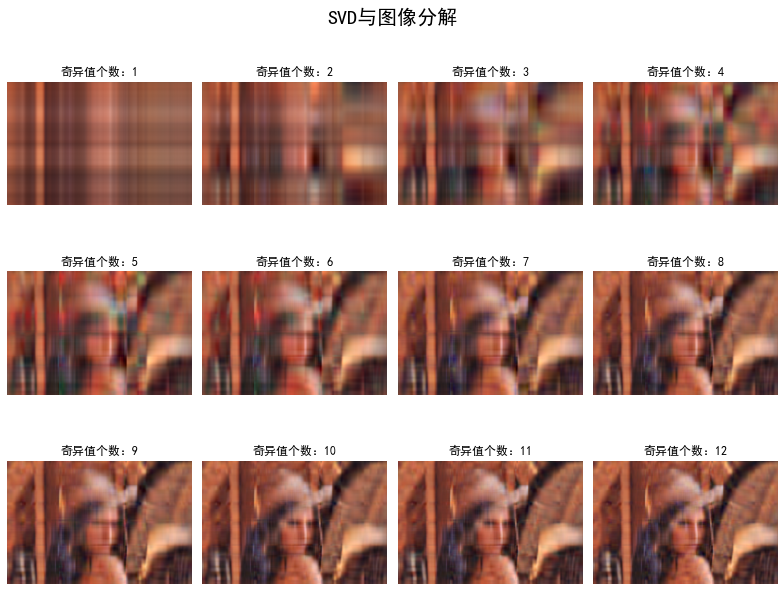

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint


def restore1(sigma, u, v, K):  # 奇异值、左特征向量、右特征向量
    m = len(u)
    n = len(v[0])
    a = np.zeros((m, n))
    for k in range(K):
        uk = u[:, k].reshape(m, 1)
        vk = v[k].reshape(1, n)
        a += sigma[k] * np.dot(uk, vk)
    a[a < 0] = 0
    a[a > 255] = 255
    # a = a.clip(0, 255)
    return np.rint(a).astype('uint8')


def restore2(sigma, u, v, K):  # 奇异值、左特征向量、右特征向量
    m = len(u)
    n = len(v[0])
    a = np.zeros((m, n))
    for k in range(K+1):
        for i in range(m):
            a[i] += sigma[k] * u[i][k] * v[k]
    a[a < 0] = 0
    a[a > 255] = 255
    return np.rint(a).astype('uint8')


if __name__ == "__main__":
    A = Image.open("C:/Users/86199/Pictures/lena/lena.jpg", 'r')
    print(A)
    output_path = r'./SVD_Output'
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    a = np.array(A)
    print(a.shape)
    K = 50
    u_r, sigma_r, v_r = np.linalg.svd(a[:, :, 0])
    u_g, sigma_g, v_g = np.linalg.svd(a[:, :, 1])
    u_b, sigma_b, v_b = np.linalg.svd(a[:, :, 2])
    plt.figure(figsize=(11, 9), facecolor='w')
    mpl.rcParams['font.sans-serif'] = ['simHei']
    mpl.rcParams['axes.unicode_minus'] = False
    for k in range(1, K+1):
        print(k)
        R = restore1(sigma_r, u_r, v_r, k)
        G = restore1(sigma_g, u_g, v_g, k)
        B = restore1(sigma_b, u_b, v_b, k)
        I = np.stack((R, G, B), axis=2)
        Image.fromarray(I).save('%s\\svd_%d.png' % (output_path, k))
        if k <= 12:
            plt.subplot(3, 4, k)
            plt.imshow(I)
            plt.axis('off')
            plt.title('奇异值个数：%d' % k)
    plt.suptitle('SVD与图像分解', fontsize=20)
    plt.tight_layout()
    # plt.subplots_adjust(top=0.9)
    plt.show()



In [ ]:
import cv2
import numpy as np

def stackImages(scale, imgArray):
    """
        将多张图像压入同一个窗口显示
        :param scale:float类型，输出图像显示百分比，控制缩放比例，0.5=图像分辨率缩小一半
        :param imgArray:元组嵌套列表，需要排列的图像矩阵
        :return:输出图像
    """
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver


#读取图片
src = cv2.imread("C:/Users/86199/Pictures/computer/coin.png")
img = src.copy()

#灰度
img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#二值化
ret, img_2 = cv2.threshold(img_1, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#腐蚀（腐蚀主要为了把每个硬币区分开。过大会造成缺失，过低会无法区分开。参数可以自己设置以达到合适。）
kernel = np.ones((17, 17), int)
img_3 = cv2.erode(img_2, kernel, iterations=1)

#膨胀（膨胀到合适的值，这样每一个白色区域就是一个硬币。）
kernel = np.ones((3, 3), int)
img_4 = cv2.dilate(img_3, kernel, iterations=1)

#找到硬币中心
contours, hierarchy = cv2.findContours(img_4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]

#标识硬币
cv2.drawContours(img, contours, -1, (0, 0, 255), 5)

#显示图片
cv2.putText(img, "count:{}".format(len(contours)), (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(src, "src", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_1, "gray", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_2, "thresh", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_3, "erode", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_4, "dilate", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
imgStack = stackImages(1, ([src, img_1, img_2], [img_3, img_4, img]))
cv2.imshow("imgStack", imgStack)
cv2.waitKey(0)



In [1]:
import cv2
import numpy as np

def stackImages(scale, imgArray):
    """
        将多张图像压入同一个窗口显示
        :param scale:float类型，输出图像显示百分比，控制缩放比例，0.5=图像分辨率缩小一半
        :param imgArray:元组嵌套列表，需要排列的图像矩阵
        :return:输出图像
    """
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver


#读取图片
src = cv2.imread("C:/Users/86199/Pictures/computer/cell.png")
img = src.copy()

#灰度
img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#二值化
ret, img_2 = cv2.threshold(img_1, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#腐蚀（腐蚀主要为了把每个硬币区分开。过大会造成缺失，过低会无法区分开。参数可以自己设置以达到合适。）
kernel = np.ones((17, 17), int)
img_3 = cv2.erode(img_2, kernel, iterations=1)

#膨胀（膨胀到合适的值，这样每一个白色区域就是一个硬币。）
kernel = np.ones((3, 3), int)
img_4 = cv2.dilate(img_3, kernel, iterations=1)

#找到硬币中心
contours, hierarchy = cv2.findContours(img_4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]

#标识硬币
cv2.drawContours(img, contours, -1, (0, 255,0), 3)

#显示图片
cv2.putText(img, "count:{}".format(len(contours)), (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(src, "src", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_1, "gray", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_2, "thresh", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_3, "erode", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_4, "dilate", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
imgStack = stackImages(1, ([src, img_1, img_2], [img_3, img_4, img]))
cv2.imshow("imgStack", imgStack)
cv2.waitKey(0)


-1

In [ ]:
import cv2
import numpy as np
import imutils
from pyzbar import pyzbar
def stackImages(scale, imgArray):
    """
        将多张图像压入同一个窗口显示
        :param scale:float类型，输出图像显示百分比，控制缩放比例，0.5=图像分辨率缩小一半
        :param imgArray:元组嵌套列表，需要排列的图像矩阵
        :return:输出图像
    """
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver


#读取图片
src = cv2.imread("C:/Users/86199/Pictures/computer/tm.png")
img = src.copy()

#灰度
img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#高斯滤波
img_2 = cv2.GaussianBlur(img_1, (5, 5), 1)


#Sobel算子
sobel_x = cv2.Sobel(img_2, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_2, cv2.CV_64F, 0, 1, ksize=3)
sobel_x = cv2.convertScaleAbs(sobel_x)
sobel_y = cv2.convertScaleAbs(sobel_y)
img_3 = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

#均值方波
img_4 = cv2.blur(img_3, (5, 5))

#二值化
ret, img_5 = cv2.threshold(img_4, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#闭运算
kernel = np.ones((18, 18), int)
img_6 = cv2.morphologyEx(img_5, cv2.MORPH_CLOSE, kernel)

#开运算
kernel = np.ones((100,100), int)
img_7 = cv2.morphologyEx(img_6, cv2.MORPH_OPEN, kernel)

#绘制条形码区域
contours = cv2.findContours(img_7, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
c = sorted(contours, key = cv2.contourArea, reverse = True)[0]
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img, [box], -1, (0,255,0), 6)

#显示图片信息
cv2.putText(img, "results", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_1, "gray", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_2, "GaussianBlur",(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_3, "Sobel", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_4, "blur", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_5, "threshold", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_6, "close", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
cv2.putText(img_7, "open", (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)

#输出条形码
barcodes = pyzbar.decode(src)
for barcode in barcodes:
    barcodeData = barcode.data.decode("utf-8")
    cv2.putText(img, barcodeData, (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)

#显示所有图片
imgStack = stackImages(0.5, ([img_1, img_2,img_3,img_4],[img_5,img_6,img_7,img]))
cv2.imshow("imgStack", imgStack)
cv2.waitKey(0)


